In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install plotinpy

In [44]:
import json
import binascii
import random
import nltk
import pandas as pd
import re
import plotinpy as pnp
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
refs = json.load(open("/content/drive/MyDrive/sem8/BDA/A1/references_grobid_10k.json","r"))
documents = refs

Creating shingles

In [ ]:
from string import punctuation
punc=list(punctuation)

In [ ]:
def get_shingles(k): 
  total=0
  document_shingles={}
  for d in documents.keys():
    document_shingles[d]=set()
    ref = ""
    for r in documents[d]:
      re.sub("\s\s+", " ", r)
      r = r.strip()
      ref+=" "+r
    ref = list(ref)
    fil_ref = [w.lower() for w in ref if w not in punc]
    n = len(ref)
    for i in range(0,n-k+1):
      # print("".join(fil_ref[i:i+k]))
      crc = binascii.crc32(("".join(fil_ref[i:i+k])).encode('utf-8')) & 0xffffffff
      document_shingles[d].add(crc)
    total+=len(document_shingles[d])
  print(total)
  return document_shingles
  # print(document_shingles[d])

In [ ]:
import hashlib
def hashFamily(i:int):
  resultSize = 8
  maxLen = 20
  salt = str(i).zfill(maxLen)[-maxLen:]
  def hashMember(x):
      sequence = x + salt
      return hashlib.sha1(sequence.encode("utf-8")).digest()[-resultSize:]
  return hashMember

Calculating signatures

In [ ]:
def calculate_signatures(document_shingles, num_hash):
  max_shingle = 2**32-1
  nextPrime = 4294967311
  # creating num_hash functions
  As=[]
  Bs=[]
  a = random.randint(0, max_shingle)
  for i in range(num_hash):
    while a in As:
      a = random.randint(0, max_shingle)
    As.append(a)
  b = random.randint(0, max_shingle)
  for i in range(num_hash):
    while b in Bs:
      b = random.randint(0, max_shingle)
    Bs.append(b)
  # print(As)
  # print(Bs)
  doc_signature={}
  for doc in document_shingles.keys():
    signature=[]
    
    for i in range(num_hash):
      min_doc_hash = 2**32-1
      for shingle in document_shingles[doc]:
        hashCode = (As[i] * shingle + Bs[i]) % nextPrime 
        min_doc_hash = min(hashCode,min_doc_hash)
        
      signature.append(min_doc_hash)

    doc_signature[doc]=signature
  return doc_signature

## LSH

In [ ]:
def get_counts(doc_signature, sig_length):
  B=[]
  counts={}
  for i in range(1,sig_length):
    if((sig_length%i)==0):
      B.append(i)
  print(B)
  count=0
  for b in B:
    count=0
    r=int(sig_length/b)
    pairs = set()
    for band in range(b):
      hash_fun=hashFamily(100)
      hash_dict={}
      for doc in doc_signature.keys():
        sig = doc_signature[doc]
        start = band*r
        end = band*r+r
        # print(start,' ',end)

        hash = hash_fun(str(tuple(sig[start:end])))
        if(hash in hash_dict.keys()):
          hash_dict[hash].append(doc)
        else:
          hash_dict[hash]=[doc]
      
      for h in hash_dict.keys():
        docs = list(hash_dict[h])
        docs.sort()
        n = len(docs)
        for i in range(n):
          for j in range(i+1,n):
            pairs.add((docs[i],docs[j]))
    thresh = (1/b)**(1/r)
    counts[thresh] = len(pairs)
    print("count: ",counts[thresh]," threshhold: ", thresh)
  return counts


In [ ]:
def get_candidate_pairs(doc_signature, b,r):
  pairs = set()
  for band in range(b):
    hash_fun=hashFamily(100)
    hash_dict={}
    for doc in doc_signature.keys():
      sig = doc_signature[doc]
      start = band*r
      end = band*r+r
      hash = hash_fun(str(tuple(sig[start:end])))
      if(hash in hash_dict.keys()):
        hash_dict[hash].append(doc)
      else:
        hash_dict[hash]=[doc]
    
    for h in hash_dict.keys():
      docs = list(hash_dict[h])
      docs.sort()
      n = len(docs)
      for i in range(n):
        for j in range(i+1,n):
          pairs.add((docs[i],docs[j]))
  thresh = (1/b)**(1/r)
  return len(pairs)

**Plotting histograms for k=5, varying similarity threshold (1/b)^(1/r)**

In [ ]:
document_shingles = get_shingles(5)
x_y = []
sig_lens=[8,16,20,24,32,36]
for sig_len in sig_lens:
  doc_signature = calculate_signatures(document_shingles, sig_len)
  counts = get_counts(doc_signature, sig_len)
  thresh = list(counts.keys())
  count = list(counts.values())
  x_y.append([thresh,count])

[1, 2, 4]
count:  9453  threshhold:  1.0
count:  9834  threshhold:  0.8408964152537145
count:  304860  threshhold:  0.5
[1, 2, 4, 8]
count:  9453  threshhold:  1.0
count:  9453  threshhold:  0.9170040432046712
count:  14097  threshhold:  0.7071067811865476
count:  1581314  threshhold:  0.3535533905932738
[1, 2, 4, 5, 10]
count:  9453  threshhold:  1.0
count:  9454  threshhold:  0.9330329915368074
count:  9735  threshhold:  0.757858283255199
count:  15145  threshhold:  0.668740304976422
count:  1828744  threshhold:  0.31622776601683794
[1, 2, 3, 4, 6, 8, 12]
count:  9453  threshhold:  1.0
count:  9453  threshhold:  0.9438743126816935
count:  9453  threshhold:  0.8716855428717357
count:  9461  threshhold:  0.7937005259840998
count:  11348  threshhold:  0.6389431042462724
count:  52275  threshhold:  0.5
count:  1188618  threshhold:  0.28867513459481287
[1, 2, 4, 8, 16]
count:  9453  threshhold:  1.0
count:  9453  threshhold:  0.9576032806985737
count:  9455  threshhold:  0.840896415253714

In [ ]:
sig_lens=[8,16,20,24,32,36]

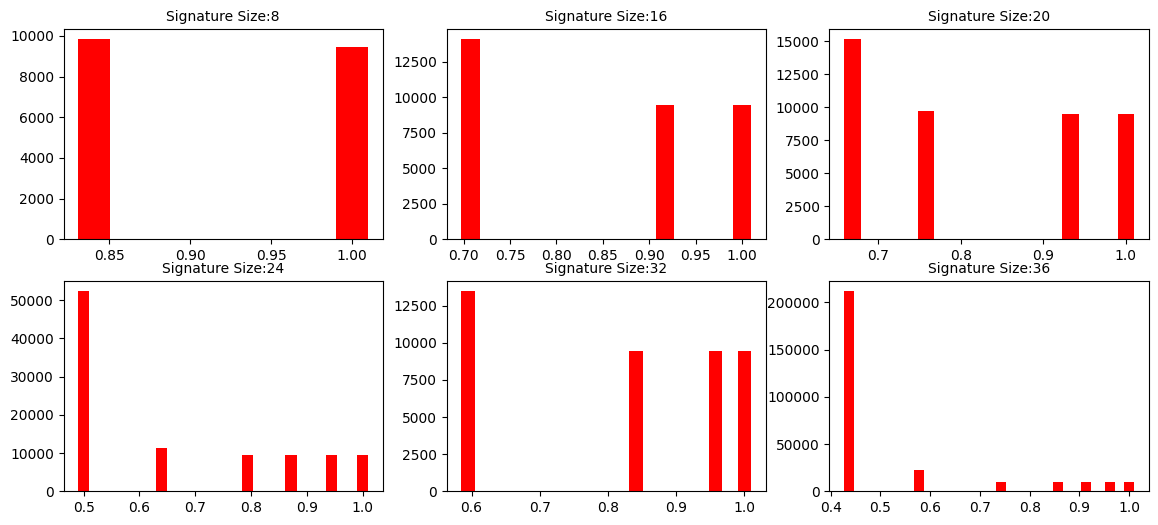

In [ ]:
fig = plt.figure(figsize = (14,6))
for i in range(1,7): 
  plt.subplot(2,3,i)
  plt.bar(x_y[i-1][0][:-1], x_y[i-1][1][:-1], color ='red', width = 0.02)
  title = "Signature Size:"+str(sig_lens[i-1])
  plt.title(title,fontsize=10)
  # plt.xlabel('similarity threshold')
  # plt.ylabel("number of pairs")
plt.show()

## Varying shingle size

In [ ]:
K=[9,10,11,12,13]
k_shingles = {}
for k in K:
  document_shingles = get_shingles(k)
  k_shingles[k] = document_shingles

13740916
14235311
14656938
15007758
15306210


In [ ]:
b=4
r=9
counts=[]
for k in k_shingles.keys():
  doc_signature = calculate_signatures(k_shingles[k], b*r)
  c = get_candidate_pairs(doc_signature, b,r)
  print("k: ",k,"c: ",c)
  counts.append(c)


k:  9 c:  9453
k:  10 c:  9453
k:  11 c:  9591
k:  12 c:  9591
k:  13 c:  9730


In [ ]:
counts_b_5_r_4 = [ 42134930, 27673177, 350720,36202,18295,10513,9877, 9512,9498, 9536, 9698, 9609, 9751]
counts_b_12_r_3 = [48096981,39197532,6722417,1028542,128999,34731,27795,36777,17775,13454,10373,9977,10207]
counts_b_4_r_9 = [27408860,586208,9824,9464,9453,9454,9453,9454,9453,9453,9591,9591,9730]

Text(0.5, 1.0, 'b = 5 r=4 s = 0.668')

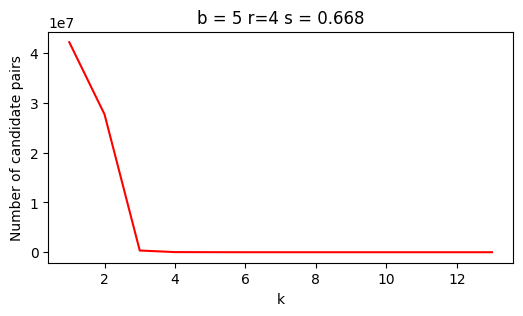

In [ ]:
import matplotlib.pyplot as plt
K=[1,2,3,4,5,6,7,8,9,10,11,12,13]
fig = plt.figure(figsize = (6,3))
plt.plot(K,counts_b_5_r_4,color='red')
plt.xlabel("k")
plt.ylabel("Number of candidate pairs")
plt.title("b = 5 r=4 s = 0.668")

Text(0.5, 1.0, 'b = 5 r=4 s = 0.668')

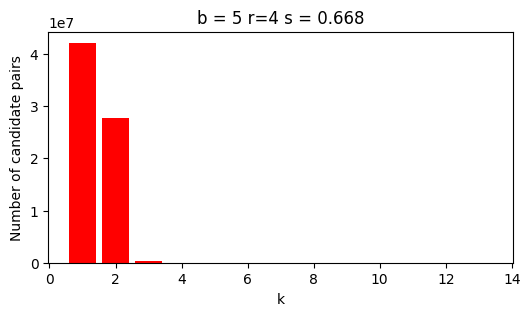

In [42]:
import matplotlib.pyplot as plt
K=[1,2,3,4,5,6,7,8,9,10,11,12,13]
fig = plt.figure(figsize = (6,3))
plt.bar(K,counts_b_5_r_4,color='red')
plt.xlabel("k")
plt.ylabel("Number of candidate pairs")
plt.title("b = 5 r=4 s = 0.668")

In [ ]:
plt.figure()
pnp.plot_bars_with_breaks(
    [1, 2, 30],
    [(15, 25)]
    )

Text(0.5, 1.0, 'b = 12 r=3 s = 0.43')

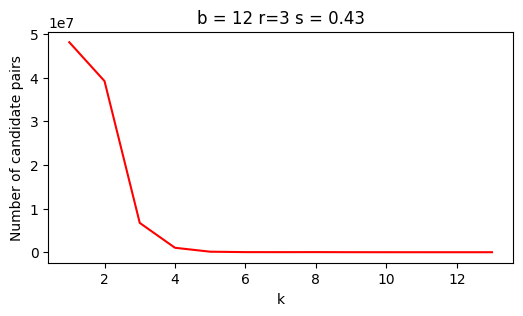

In [ ]:
import matplotlib.pyplot as plt
K=[1,2,3,4,5,6,7,8,9,10,11,12,13]
fig = plt.figure(figsize = (6,3))
plt.plot(K,counts_b_12_r_3,color='red')
plt.xlabel("k")
plt.ylabel("Number of candidate pairs")
plt.title("b = 12 r=3 s = 0.43")

Text(0.5, 1.0, 'b = 12 r=3 s = 0.43')

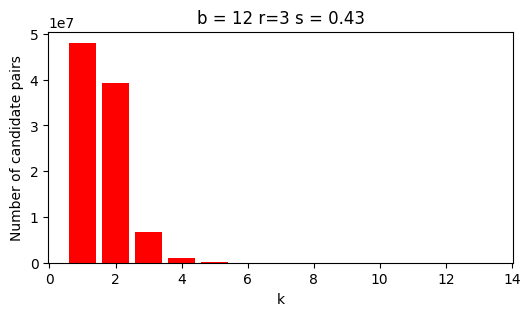

In [40]:
import matplotlib.pyplot as plt
K=[1,2,3,4,5,6,7,8,9,10,11,12,13]
fig = plt.figure(figsize = (6,3))
plt.bar(K,counts_b_12_r_3,color='red')
plt.xlabel("k")
plt.ylabel("Number of candidate pairs")
plt.title("b = 12 r=3 s = 0.43")

Text(0.5, 1.0, 'b = 4 r=9 s = 0.85')

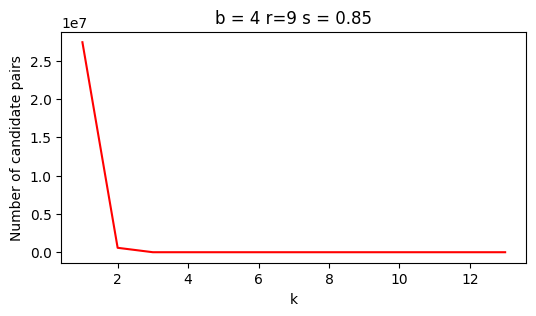

In [ ]:
import matplotlib.pyplot as plt
K=[1,2,3,4,5,6,7,8,9,10,11,12,13]
fig = plt.figure(figsize = (6,3))
plt.plot(K,counts_b_4_r_9,color='red')
plt.xlabel("k")
plt.ylabel("Number of candidate pairs")
plt.title("b = 4 r=9 s = 0.85")

Text(0.5, 1.0, 'b = 4 r=9 s = 0.85')

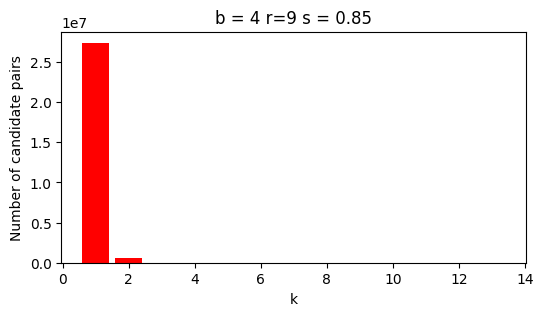

In [41]:
import matplotlib.pyplot as plt
K=[1,2,3,4,5,6,7,8,9,10,11,12,13]
fig = plt.figure(figsize = (6,3))
plt.bar(K,counts_b_4_r_9,color='red')
plt.xlabel("k")
plt.ylabel("Number of candidate pairs")
plt.title("b = 4 r=9 s = 0.85")

Text(0.5, 1.0, 'Similar pairs for different similarites and k')

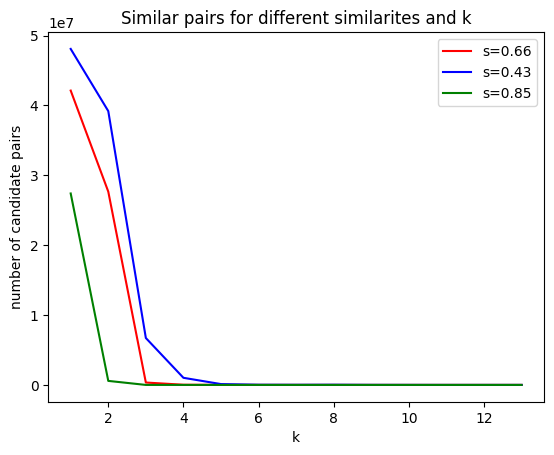

In [36]:
plt.plot(K,counts_b_5_r_4,color='red',label="s=0.66")
plt.plot(K,counts_b_12_r_3,color='blue',label="s=0.43")
plt.plot(K,counts_b_4_r_9,color='green',label="s=0.85")
plt.legend()
plt.xlabel("k")
plt.ylabel("number of candidate pairs")
plt.title("Similar pairs for different similarites and k")

References: 

MinHash: https://github.com/chrisjmccormick/MinHash/blob/master/runMinHashExample.py

LSH: https://github.com/GianRomani/LSH/blob/main/LSH.py
